# Chaining Samplers

A single sampler can optimise towards a single goal.
If you chanin a lot of samplers you might be able to maximise towards multiple goals.


## initialising logging,notebook and a way to obtain graphs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)
dataset_fname = '../toolsdata/bursi.pos.gspan'
dataset_fname2 = '../toolsdata/bursi.neg.gspan'

!date

Wed Jun 29 23:11:20 CEST 2016


## training some samplers

notice that sampler_b is trained on the negative set.

In [2]:
%%time
from graphlearn.graphlearn import  Sampler
from eden.graph import Vectorizer
import traceback
from graphlearn.localsubstitutablegraphgrammar import LocalSubstitutableGraphGrammar
# get two samplers ready
n_steps=30
sampler_a=Sampler(grammar=LocalSubstitutableGraphGrammar(radius_list=[0,1], 
                thickness_list=[2],
                min_cip_count=2, 
                min_interface_count=2),size_diff_core_filter=3,
                    n_steps=n_steps,
                    improving_threshold_fraction=.5,
                    improving_linear_start_fraction=0.0,
                    probabilistic_core_choice=False,
                    score_core_choice=True)

sampler_b=Sampler(grammar=LocalSubstitutableGraphGrammar(radius_list=[0,1], 
                thickness_list=[2],
                min_cip_count=2, 
                min_interface_count=2),size_diff_core_filter=3,
                    n_steps=n_steps,
                    improving_threshold_fraction=.5,
                    improving_linear_start_fraction=0.0,
                    probabilistic_core_choice=False,
                    score_core_choice=True)
sampler_c=Sampler(grammar=LocalSubstitutableGraphGrammar(radius_list=[0,3], 
                thickness_list=[2],
                min_cip_count=2, 
                min_interface_count=2),size_diff_core_filter=3,
                    n_steps=n_steps,
                    improving_threshold_fraction=.5,
                    improving_linear_start_fraction=0.0,
                    probabilistic_core_choice=False,
                    score_core_choice=True)

sampler_d=Sampler(grammar=LocalSubstitutableGraphGrammar(radius_list=[0,4], 
                thickness_list=[2],
                min_cip_count=2, 
                min_interface_count=1),size_diff_core_filter=3,
                    n_steps=n_steps,
                    improving_threshold_fraction=.5,
                    improving_linear_start_fraction=0.0,
                    probabilistic_core_choice=False,
                    score_core_choice=True)

training_graphs = get_graphs(dataset_fname, size=200)
sampler_a.fit(training_graphs)

training_graphs_ii = get_graphs(dataset_fname2, size=200)
sampler_b.fit(training_graphs_ii)

'''
training_graphs_iii = get_graphs(dataset_fname, size=100)
sampler_c.fit(training_graphs_iii)
training_graphs_iv = get_graphs(dataset_fname, size=100)
sampler_d.fit(training_graphs_iv)
'''

CPU times: user 8.03 s, sys: 876 ms, total: 8.91 s
Wall time: 18.3 s


# combining samplers.

Combining samplers is fairly simple. 

Most of the code below is spent setting up the data collecting monitors that give us a score history later.

Thanks to a few lines of code in the graphlearn class, expressions like these are possible: 
samplercombiner((sampler_a+ sampler_b)-(sampler_b + sampler_c))

Samplers dont have their own arguments (yet).

In [3]:
from graphlearn.utils.monitor import Monitor

class samplercombiner(object):
    
    def __init__(self,graphlearn):
        self.parse(graphlearn)
        
    def getspawns(self, graphlearn):
        '''
        the graphsampler expression is like a tree.
        we turn this into a list and make every graphlearner write into the same monitor object.
        so taht we should be able to run all the sampler sequentially
        
        we also make graphlearn treat our injected monitor object with respect
        '''
        graphlearn._sample_init_init_monitor=lambda : 0
        def f(s,g):
            s.monitorobject.superscorelist.append(g._score)
            s._score_list.append(g._score)
        funcType = type(graphlearn._score_list_append)
        graphlearn._score_list_append = funcType(f, graphlearn, Sampler)
        
        
        li=[graphlearn]
        for gl in graphlearn.__dict__.get('spawn_list',[]):
            li+=self.getspawns(gl)
        return li

    
    def parse(self,graphlearn):
        self.learners=self.getspawns(graphlearn)
        return self
    
    def what(self):
        for e in self.learners:
            print e.lsgg.radius_list, e.estimatorobject.inverse_prediction
    
    def fixmonitor(self, monitor,padlength):
        '''
        sampling may stop at any moment -> needs padding in monitor
        '''
        currentlen= len(monitor.superscorelist)
        if currentlen == 0:
            monitor.superscorelist.append(0)
        monitor.superscorelist+= [monitor.superscorelist[-1]] * (padlength-currentlen)
    
    def run_single_graph(self,graph,repeats=2):
        # set monitors:
        monitor=Monitor(active=True)
        monitor.superscorelist=[]
        for sampler in self.learners:
            sampler.monitorobject=monitor

        # REPEAT times repeat the samplers in the list
        n_steps=50
        self.steps=n_steps*repeats*len(self.learners)
        print self.steps
        
        for repeat in range(repeats):
            for samplernum, sampler in enumerate(self.learners):
                samplerresults = sampler.transform(
                    graph_iter=[graph])
                self.fixmonitor(sampler.monitorobject,repeat*len(self.learners)*n_steps+(samplernum)*n_steps)
                graph=samplerresults.next()[0]
        return graph,monitor

        
    def run_multi_graph(self,graphs,repeats=2):
        for graph in graphs:
            res=self.run_single_graph(graph,repeats=repeats)
            # just hide the failures
            if res != None:
                yield res
            
#sc=samplercombiner((sampler_a+ sampler_b)-(sampler_b + sampler_c))
#sc.what()
sc=samplercombiner(sampler_a - sampler_b)
sc.what()

[0, 2] False
[0, 2] True


# Sample and show generated graphs

In [4]:
%%time
# RUN SAMPLER
from itertools import islice
graphs = get_graphs(dataset_fname, size=100)
id_start=34
id_end=id_start+6
input_graphs = islice(graphs,id_start,id_end)
results=sc.run_multi_graph(input_graphs,repeats=2)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 18.8 µs


200
Graph id: 34


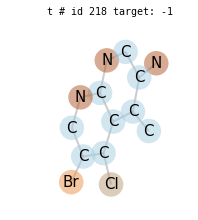

200
Graph id: 35


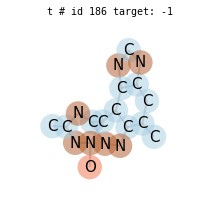

200
Graph id: 36


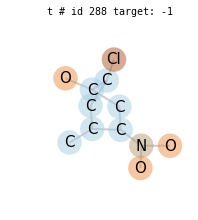

200
Graph id: 37


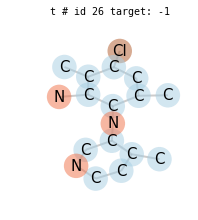

200
Graph id: 38


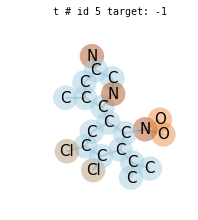

200
Graph id: 39


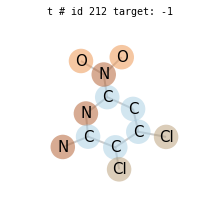

In [5]:
# Iterate sampler results, save information and show graphs
from graphlearn.utils import selectdraw
monitors=[]
ids=range(id_start,id_end)
for i,res in enumerate(results):
    print 'Graph id: %d'%(ids[i])
    monitors.append(res[1])
    graphlist=res[0]
    selectdraw(graphlist,contract=False,
                   n_graphs_per_line=6, size=3, 
                   colormap='Paired', invert_colormap=False, vertex_color='_labels_',
                   vertex_alpha=0.5, edge_alpha=0.2)

In [6]:
scores=[]               
for mon in monitors: 
    scores.append( mon.superscorelist)

# Show sample score history

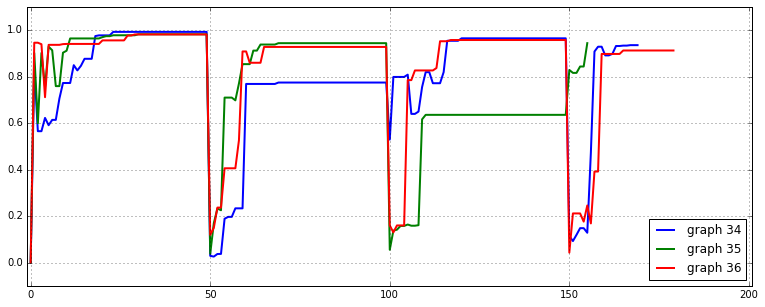

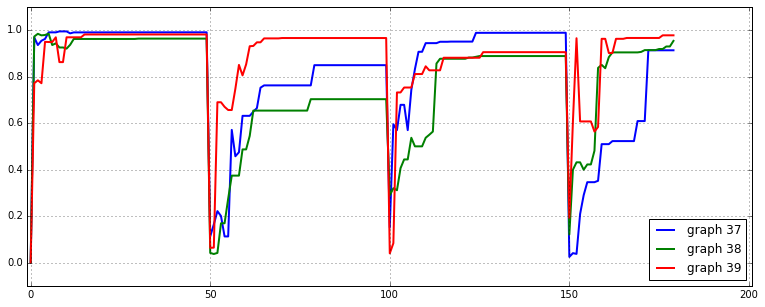

CPU times: user 236 ms, sys: 4 ms, total: 240 ms
Wall time: 239 ms


In [7]:
%%time
# plot sampling path score
from itertools import islice
import numpy as np
import pylab as plt
SUMSTEPS=sc.steps
markevery=5
step=1
num_graphs_per_plot=3
num_plots=np.ceil([len(scores)/num_graphs_per_plot])
for i in range(num_plots):

    plt.figure(figsize=(13,5))
    for j,score in enumerate(scores[i*num_graphs_per_plot:i*num_graphs_per_plot+num_graphs_per_plot]):
     
        data = list(islice(score,None, None, step))
        plt.plot(data, linewidth=2, label='graph %d'%(j+i*num_graphs_per_plot+id_start))
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlim(-1,SUMSTEPS+1)
    plt.ylim(-0.1,1.1)
    plt.show()

---